# Fake News Detection #

This project implements an end-to-end Natural Language Processing (NLP) and Machine Learning pipeline for detecting fake news articles. The workflow combines traditional text preprocessing, statistical feature extraction, unsupervised topic modeling, and supervised classification techniques to analyze and classify news content.

## Project Highlights

### **Data preprocessing & cleaning**
- Text normalization  
- Tokenization  
- Stopword removal  

### **Feature engineering**
- Bag-of-Words representation  
- TF-IDF vectorization  

### **Unsupervised topic modeling**
- Latent Dirichlet Allocation (LDA)  
- Latent Semantic Indexing (LSI)  
- Coherence scoring for model evaluation  

### **Supervised machine learning**
- Logistic Regression classifier  
- Linear Support Vector Machine (SVM via SGDClassifier)  

### **Model evaluation**
- Train/test split  
- Classification metrics (accuracy, precision, recall, etc.)  
- Topic coherence analysis  

---

This project demonstrates how to build a complete NLP-based classification system from raw, unstructured text to interpretable topics and predictive models capable of distinguishing real news from fake news.

### Data ###
The dataset used in this project was obtained from Kaggle at the following link: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
This dataset was chosen to model real-world production grade data.
This dataset includes 72,134 new articles with 37,106 factual articles and 35,028 fake news articles. 

In [162]:
# set plot options
plt.rcParams['figure.figsize'] = (12, 8)
default_plot_colour = "#87CEEB"

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [164]:
df = pd.read_csv("WELFake_Dataset.csv", index_col=0)

In [165]:
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [166]:
df['fake_or_factual'] = np.where(df['label'] == 0, "Fake News", "Factual News")

In [167]:
df.head()

,title,text,label,fake_or_factual
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,Factual News
1,NaN,Did they post their votes for Hillary already?,1,Factual News
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,Factual News
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,Fake News
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,Factual News


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            71576 non-null  object
 1   text             72095 non-null  object
 2   label            72134 non-null  int64 
 3   fake_or_factual  72134 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


Text(0.5, 0, 'Classification')

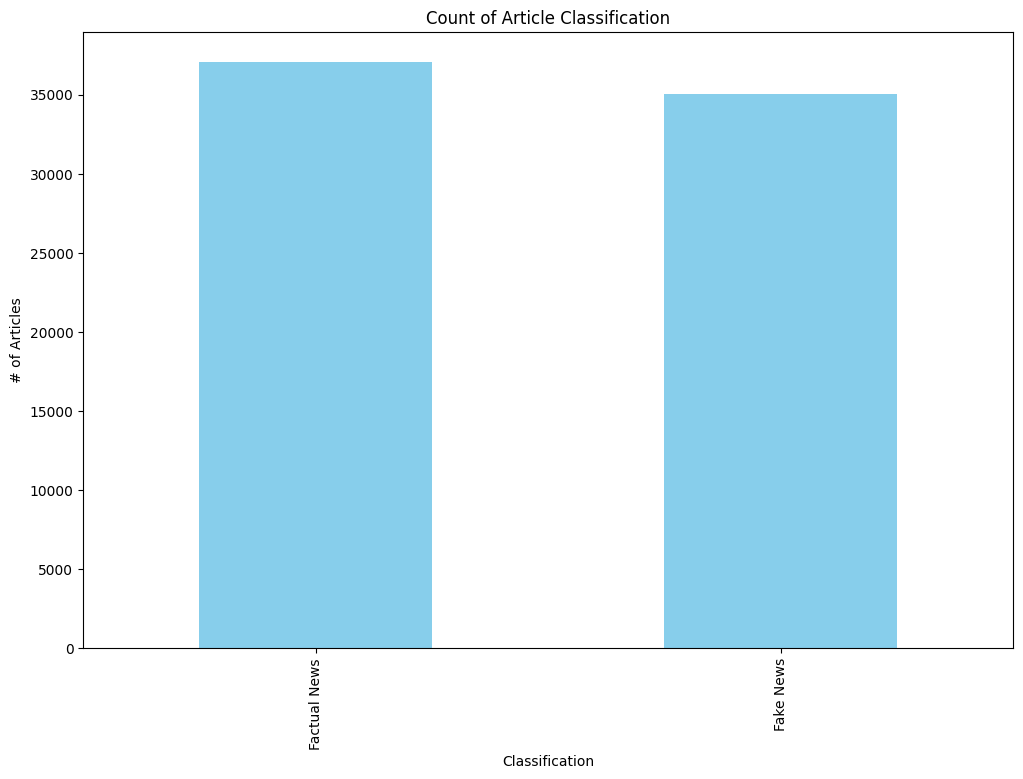

In [169]:
# plot number of fake and factual articles - make sure the values are relatively proportional
df['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_colour)
plt.title('Count of Article Classification')
plt.ylabel('# of Articles')
plt.xlabel('Classification')

### Import packages required for processing and analysis ###

In [170]:
%%capture
pip install seaborn

In [171]:
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

### POS (Parts of Speech) Tagging ###

POS tagging assigns each word in a sentence a label that describes its role—like noun, verb, adjective, etc. It helps NLP systems understand the structure and meaning of text.

In [172]:
nlp = spacy.load('en_core_web_sm')

In [173]:
# split data by fake and factual news
fake_news = df[df['fake_or_factual'] == "Fake News"]
fact_news = df[df['fake_or_factual'] == "Factual News"]

In [174]:
fake_news.head()

,title,text,label,fake_or_factual
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,Fake News
11,"May Brexit offer would hurt, cost EU citizens ...",BRUSSELS (Reuters) - British Prime Minister Th...,0,Fake News
12,Schumer calls on Trump to appoint official to ...,"WASHINGTON (Reuters) - Charles Schumer, the to...",0,Fake News
14,No Change Expected for ESPN Political Agenda D...,As more and more sports fans turn off ESPN to ...,0,Fake News
15,Billionaire Odebrecht in Brazil scandal releas...,RIO DE JANEIRO/SAO PAULO (Reuters) - Billionai...,0,Fake News


In [175]:
fact_news.head()

,title,text,label,fake_or_factual
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,Factual News
1,NaN,Did they post their votes for Hillary already?,1,Factual News
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,Factual News
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,Factual News
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,Factual News


In [176]:
# create spacy documents - use pipe for dataframe
#fake_spacydocs = list(nlp.pipe(fake_news['text'])) # too slow... batch process

In [177]:
#fake_texts = fake_news["text"].astype(str)  # avoid None/NaN issues

In [178]:
"""fake_spacydocs = list(
    nlp.pipe(
        fake_texts,
        batch_size=100,   # tunable: 100–2000 
        n_process=8       # disperse over 6 cores
    )
) """

'fake_spacydocs = list(\n    nlp.pipe(\n        fake_texts,\n        batch_size=100,   # tunable: 100–2000 \n        n_process=8       # disperse over 6 cores\n    )\n) '

In [179]:
#from spacy.tokens import DocBin

"""doc_bin = DocBin(store_user_data=True)

for doc in fake_spacydocs:      # docs = list of spaCy Doc objects
    doc_bin.add(doc)

doc_bin.to_disk("parsed_fake_docs.spacy") """

'doc_bin = DocBin(store_user_data=True)\n\nfor doc in fake_spacydocs:      # docs = list of spaCy Doc objects\n    doc_bin.add(doc)\n\ndoc_bin.to_disk("parsed_fake_docs.spacy") '

In [180]:
#fact_texts = fact_news["text"].astype(str)  # avoid None/NaN issues

In [181]:
"""fact_spacydocs = list(
    nlp.pipe(
        fact_texts,
        batch_size=100,   # tunable: 100–2000
        n_process=6       # disperse over 6 cores
    )
) """

'fact_spacydocs = list(\n    nlp.pipe(\n        fact_texts,\n        batch_size=100,   # tunable: 100–2000\n        n_process=6       # disperse over 6 cores\n    )\n) '

In [182]:
"""doc_bin = DocBin(store_user_data=True)

for doc in fact_spacydocs:      # docs = list of spaCy Doc objects
    doc_bin.add(doc)

doc_bin.to_disk("parsed_fact_docs.spacy") """

'doc_bin = DocBin(store_user_data=True)\n\nfor doc in fact_spacydocs:      # docs = list of spaCy Doc objects\n    doc_bin.add(doc)\n\ndoc_bin.to_disk("parsed_fact_docs.spacy") '

In [183]:
# Don't create new spacy docs each time 
from spacy.tokens import DocBin

In [184]:
fake_doc_bin = DocBin().from_disk("parsed_fake_docs.spacy")
fake_spacydocs = list(fake_doc_bin.get_docs(nlp.vocab))

In [185]:
fact_doc_bin = DocBin().from_disk("parsed_fact_docs.spacy")
fact_spacydocs = list(fake_doc_bin.get_docs(nlp.vocab))

In [186]:
from nltk.corpus import stopwords
en_stopwords = set(stopwords.words('english'))

In [187]:
# create function to extract tags for each document in our data
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [188]:
# tag fake dataset 
fake_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)
        
fake_tagsdf = pd.concat(fake_tagsdf)   

# tag factual dataset 
fact_tagsdf = []

for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)
        
fact_tagsdf = pd.concat(fact_tagsdf) 

In [189]:
fake_tagsdf["token_norm"] = fake_tagsdf["token"].str.lower()

In [190]:
fact_tagsdf["token_norm"] = fact_tagsdf["token"].str.lower()

In [191]:
# relevant content POS tags 
content_pos = ["NOUN", "PROPN", "VERB", "ADJ", "ADV"]

In [117]:
fake_mask = (
    (fake_tagsdf["pos_tag"].isin(content_pos)) &                    
    (~fake_tagsdf["token_norm"].isin(en_stopwords)) &               
    (fake_tagsdf["pos_tag"] != "PUNCT") &                          
    (fake_tagsdf["token_norm"].str.strip().ne(""))                  
)

fake_content = fake_tagsdf[fake_mask]

In [118]:
fact_mask = (
    (fact_tagsdf["pos_tag"].isin(content_pos)) &                    
    (~fact_tagsdf["token_norm"].isin(en_stopwords)) &               
    (fact_tagsdf["pos_tag"] != "PUNCT") &                           
    (fact_tagsdf["token_norm"].str.strip().ne(""))                  
)

fact_content = fact_tagsdf[fact_mask]

In [119]:
top_tokens_fake = (
    fake_content["token_norm"]
    .value_counts()
    .head(10)
)

In [120]:
top_tokens_fact = (
    fact_content["token_norm"]
    .value_counts()
    .head(10)
)

In [121]:
top_tokens_fake

token_norm
said         184581
trump        106979
mr.           65896
president     51292
new           42524
u.s.          41831
people        41786
state         38855
also          36608
states        31665
Name: count, dtype: int64

In [122]:
top_tokens_fact

token_norm
said         184581
trump        106979
mr.           65896
president     51292
new           42524
u.s.          41831
people        41786
state         38855
also          36608
states        31665
Name: count, dtype: int64

In [123]:
# Differences in top nouns
top_nouns_fake = (
    fake_content[fake_content["pos_tag"] == "NOUN"]["token_norm"]
    .value_counts()
    .head(15)
)

print(top_nouns_fake)

token_norm
people        41040
government    29044
year          27751
state         22815
campaign      22786
time          22702
years         22072
president     21263
percent       20323
country       18790
election      18181
officials     16523
party         15883
week          15767
law           14925
Name: count, dtype: int64


In [124]:
top_nouns_fact = (
    fact_content[fact_content["pos_tag"] == "NOUN"]["token_norm"]
    .value_counts()
    .head(15)
)

print(top_nouns_fact)

token_norm
people        41040
government    29044
year          27751
state         22815
campaign      22786
time          22702
years         22072
president     21263
percent       20323
country       18790
election      18181
officials     16523
party         15883
week          15767
law           14925
Name: count, dtype: int64


In [125]:
# create wordcloud display of top nouns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(token_series, title="Word Cloud"):
    # convert Series to dict
    freqs = token_series.to_dict()
    # build the word cloud
    wc = WordCloud(
        width=500,
        height=500,
        background_color="white",
        colormap="Blues"   
    ).generate_from_frequencies(freqs)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=18)
    plt.show()

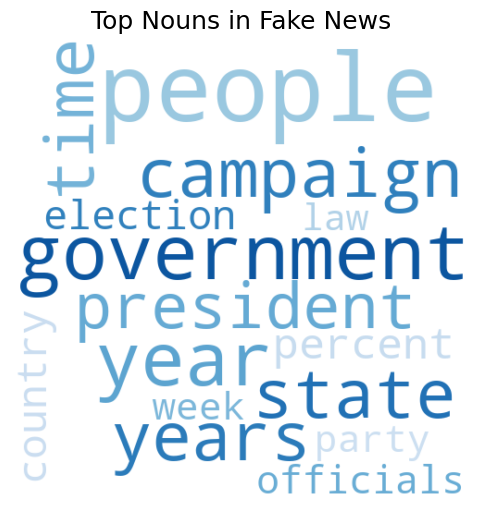

In [126]:
# this would benefit from lemmatization (year, years both are present)
generate_wordcloud(top_nouns_fake, title="Top Nouns in Fake News")

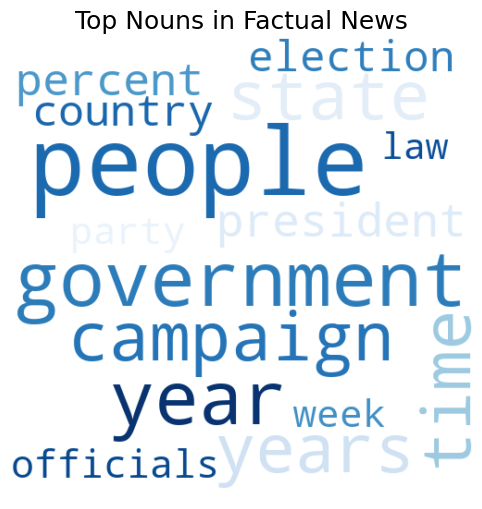

In [127]:
generate_wordcloud(top_nouns_fact, title="Top Nouns in Factual News")

### Extracting Named Entities ###

This analysis applies named entity recognition (NER) to extract and rank the most frequently mentioned real world entities such as people, organizations, locations, and dates. By filtering and aggregating entity labels, it highlights which entities dominate fake versus factual news, revealing differences in narrative focus and framing. The results are standardized and visualized with a consistent color palette to support clear comparisons.

In [128]:
# top entities in fake news
mask = fake_tagsdf["ner_tag"].ne("")  

top_entities_fake = (
    fake_tagsdf.loc[mask, ["token", "ner_tag"]]
    .value_counts()
    .head(10)                            # cut early, less data to handle
    .reset_index(name="counts")
)

In [129]:
# top entities in fact news
mask = fact_tagsdf["ner_tag"].ne("")  

top_entities_fact = (
    fact_tagsdf.loc[mask, ["token", "ner_tag"]]
    .value_counts()
    .head(10)                            
    .reset_index(name="counts")
)

In [130]:
# create custom palette to ensure plots are consistent
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

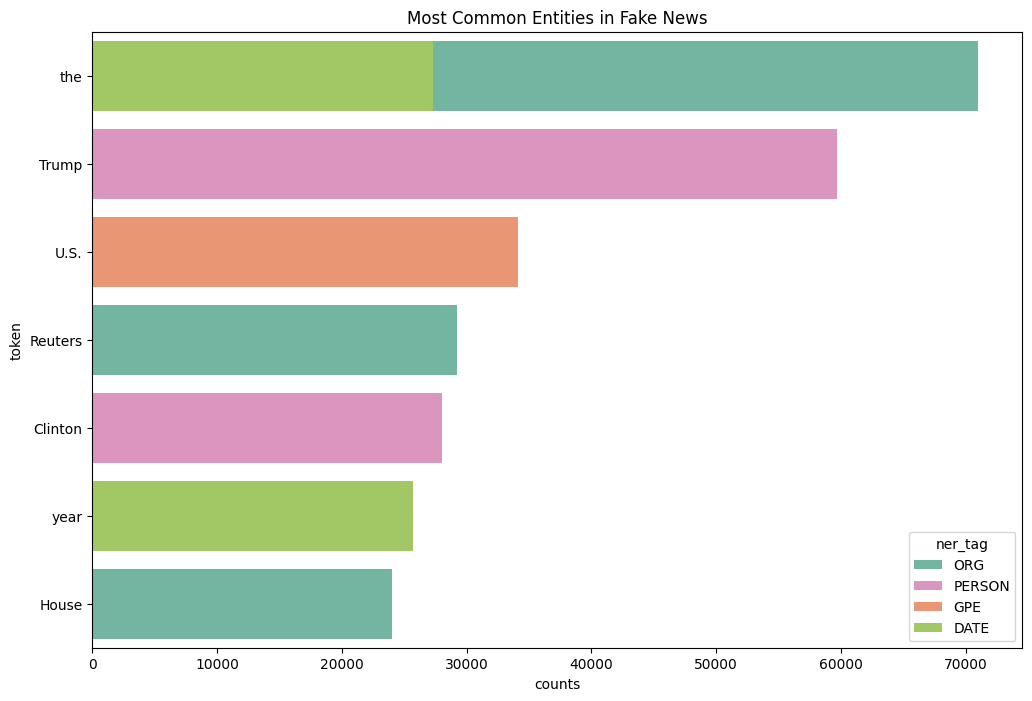

In [131]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Factual News')]

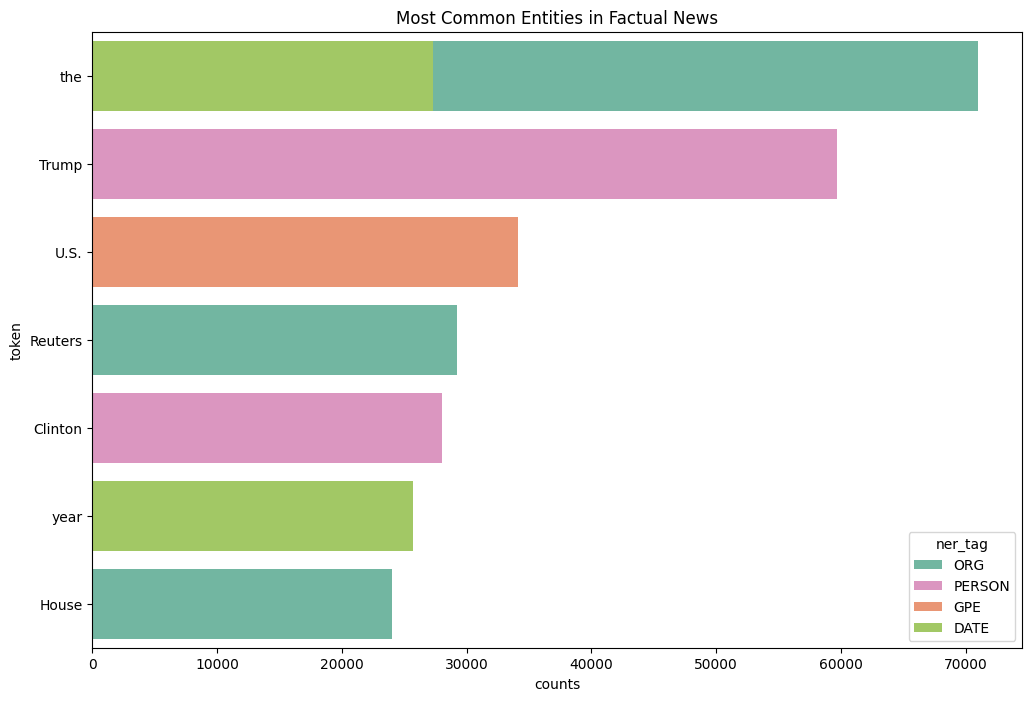

In [132]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Factual News')

### Text Pre-processing ###

Text pre-processing involves cleaning and normalizing the raw article text to prepare it for vectorization and modeling. This includes removing irrelevant characters, standardizing word forms, separating tokens, and filtering out non-informative terms.

In [133]:
df['text'].apply(type).value_counts()

text
<class 'str'>      72095
<class 'float'>       39
Name: count, dtype: int64

In [134]:
# a lot of the factual news has a location tag at the beginning of the article, use regex to remove this
df['text'] = df['text'].astype(str)
df['text_clean'] = df.apply(lambda x: re.sub(r"^[^-]*-\s*", "", x['text']), axis=1)

In [135]:
# lowercase 
df['text_clean'] = df['text_clean'].str.lower()

In [136]:
# remove punctuation
df['text_clean'] = df.apply(lambda x: re.sub(r"([^\w\s])", "", x['text_clean']), axis=1)

In [137]:
# stop words
en_stopwords = stopwords.words('english')
print(en_stopwords) # check this against our most frequent n-grams

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [138]:
df['text_clean'] = df['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [139]:
# tokenize 
df['text_clean'] = df.apply(lambda x: word_tokenize(x['text_clean']), axis=1)

In [140]:
# lemmatize
lemmatizer = WordNetLemmatizer()
df["text_clean"] = df["text_clean"].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [141]:
df.head()

,title,text,label,fake_or_factual,text_clean
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,Factual News,"[as, r, war, niers, going, start, backin, alre..."
1,NaN,Did they post their votes for Hillary already?,1,Factual News,"[post, vote, hillary, already]"
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,Factual News,"[demonstrator, gathered, last, night, exercisi..."
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,Fake News,"[thescenes, effort, louisiana, governor, find,..."
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,Factual News,"[28, sarmat, missile, dubbed, satan, 2, replac..."


In [142]:
# most common unigrams after preprocessing
from collections import Counter
import itertools

def window(seq, n=1):
    it = iter(seq)
    win = list(itertools.islice(it, n))
    if len(win) == n:
        yield tuple(win)
    for elem in it:
        win = win[1:] + [elem]
        yield tuple(win)

tokens_clean_iter = itertools.chain.from_iterable(df['text_clean'])
unigrams = Counter(tokens_clean_iter).most_common(10)
print(unigrams)

[('said', 223131), ('trump', 180859), ('state', 102716), ('u', 98238), ('would', 97883), ('people', 82075), ('one', 80026), ('president', 78074), ('mr', 77170), ('year', 69099)]


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

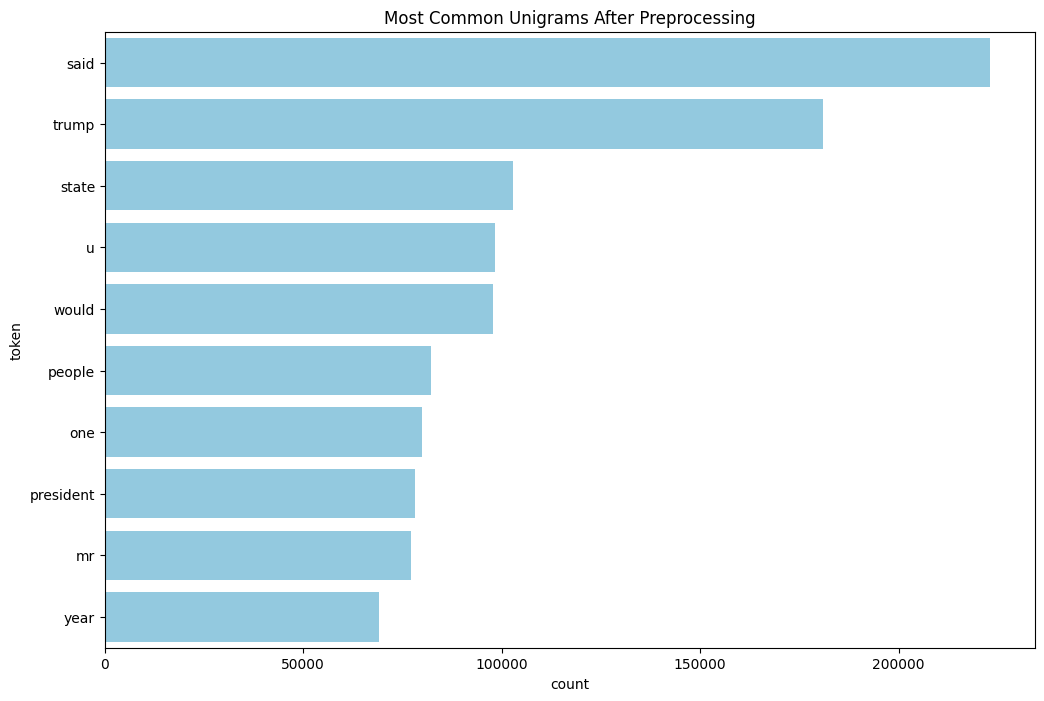

In [143]:
unigrams = df['text_clean'].explode().value_counts().head(10).reset_index()
unigrams.columns = ['token', 'count']

sns.barplot(
    x="count",
    y="token",
    data=unigrams,
    orient="h",
    color=default_plot_colour  
).set(title="Most Common Unigrams After Preprocessing")

In [144]:
# most common bigrams after preprocessing
tokens_clean_iter = itertools.chain.from_iterable(df['text_clean'])
bigrams = Counter(window(tokens_clean_iter, 2)).most_common(10)
print(bigrams)

[(('united', 'state'), 31422), (('donald', 'trump'), 27139), (('white', 'house'), 20975), (('mr', 'trump'), 18857), (('hillary', 'clinton'), 17390), (('new', 'york'), 17017), (('last', 'year'), 8461), (('president', 'donald'), 7644), (('north', 'korea'), 7568), (('last', 'week'), 7321)]


### Sentiment Analysis ###

Sentiment scores were computed using VADER’s SentimentIntensityAnalyzer(), which evaluates the emotional tone of each article based on positive, negative, and neutral word patterns.

In [145]:
# use vader so we also get a neutral sentiment count
vader_sentiment = SentimentIntensityAnalyzer()

In [146]:
# work on a sample set to do exploration due to dataset size
sample = df.sample(10000, random_state=0)
sample['vader_sentiment_score'] = sample['text'].astype(str).apply(
    lambda review: vader_sentiment.polarity_scores(review)['compound']
)

In [147]:
# create labels
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

sample['vader_sentiment_label'] = pd.cut(sample['vader_sentiment_score'], bins, labels=names)

<Axes: xlabel='vader_sentiment_label'>

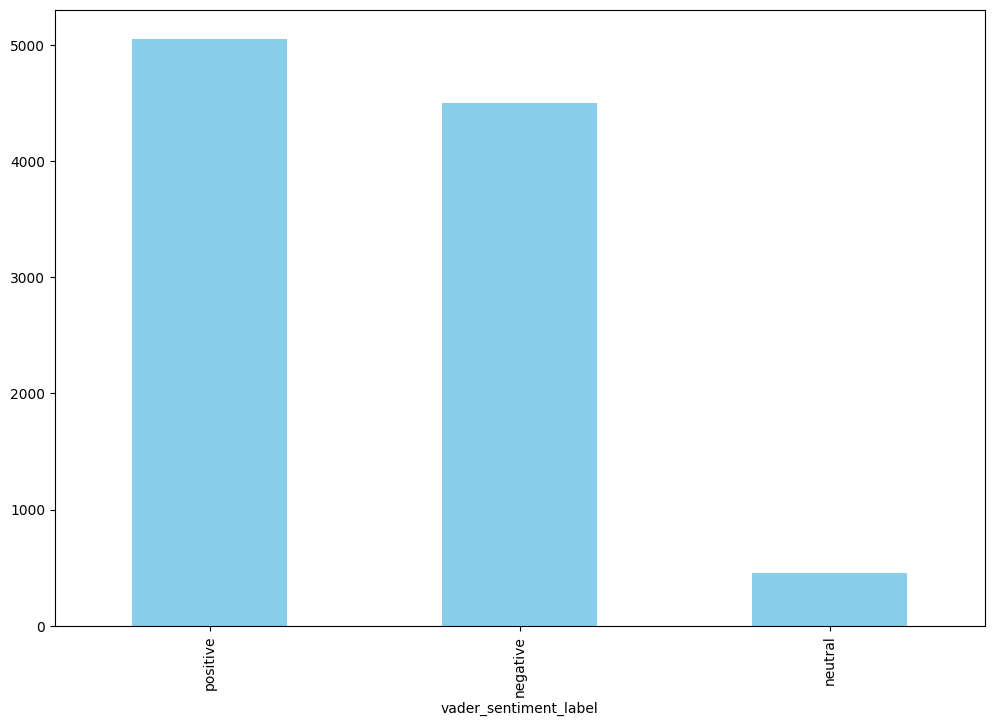

In [70]:
sample['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_colour)

[Text(0.5, 1.0, 'Sentiment by News Type')]

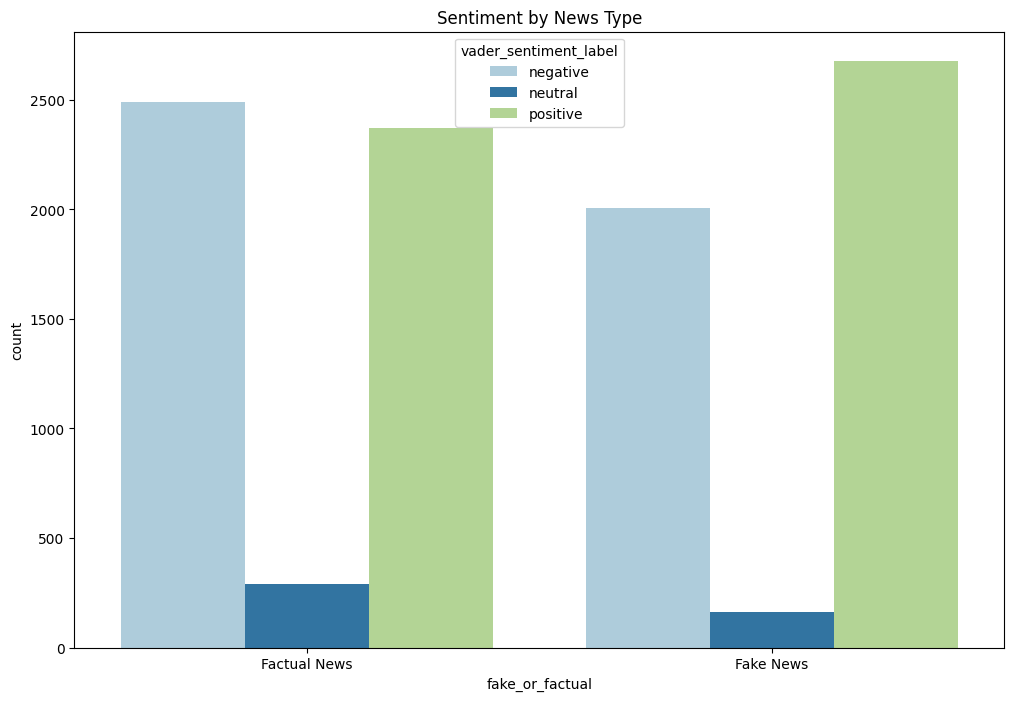

In [72]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette("Paired", n_colors=3),
    data = sample
) \
.set(title='Sentiment by News Type')

### LDA ###

Latent Dirichlet Allocation (LDA) is an unsupervised topic modeling algorithm that discovers hidden themes in a text corpus by grouping words that frequently appear together. It represents each document as a mixture of latent topics and each topic as a distribution over words.

In [73]:
# fake news data vectorization
fake_news_text = df[df['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop=True)
dictionary_fake = corpora.Dictionary(fake_news_text)
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

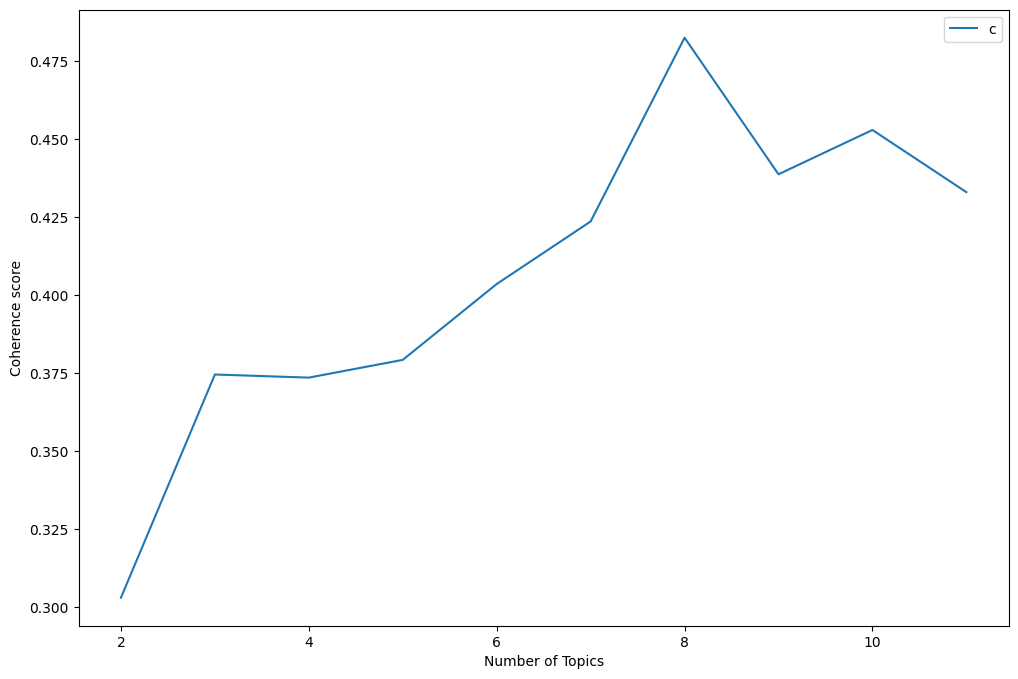

In [74]:
# generate coherence scores to determine an optimum number of topics
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
    
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [75]:
# create lda model
num_topics_fake = 8 

lda_model_fake = gensim.models.LdaModel(corpus=doc_term_fake,
                                       id2word=dictionary_fake,
                                       num_topics=num_topics_fake)

lda_model_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.021*"said" + 0.013*"trump" + 0.010*"u" + 0.009*"court" + 0.008*"state" + 0.008*"president" + 0.006*"would" + 0.006*"law" + 0.006*"official" + 0.005*"department"'),
 (1,
  '0.018*"said" + 0.011*"government" + 0.009*"party" + 0.007*"minister" + 0.006*"would" + 0.006*"country" + 0.006*"european" + 0.005*"eu" + 0.005*"year" + 0.005*"leader"'),
 (2,
  '0.014*"said" + 0.012*"republican" + 0.012*"would" + 0.011*"tax" + 0.010*"house" + 0.009*"bill" + 0.007*"senate" + 0.006*"trump" + 0.006*"state" + 0.006*"year"'),
 (3,
  '0.036*"trump" + 0.015*"said" + 0.014*"clinton" + 0.011*"republican" + 0.009*"campaign" + 0.008*"state" + 0.007*"president" + 0.006*"party" + 0.006*"election" + 0.006*"candidate"'),
 (4,
  '0.024*"said" + 0.010*"police" + 0.007*"state" + 0.007*"people" + 0.006*"city" + 0.006*"attack" + 0.005*"group" + 0.005*"killed" + 0.004*"one" + 0.004*"two"'),
 (5,
  '0.022*"said" + 0.017*"u" + 0.015*"state" + 0.012*"united" + 0.011*"trump" + 0.010*"china" + 0.010*"president" + 0.

### TF-IDF & LSA ###

In [76]:
import random

In [77]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vecotization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf 

In [78]:
def get_coherence_scores (
    corpus_tfidf,
    dictionary,
    texts,
    min_topics=2,
    max_topics=11,
    max_docs_for_coh=3000,
    processes=4
):
    # 1) sample docs for coherence (speed)
    n = len(texts)
    if n > max_docs_for_coh:
        random.seed(0)
        idx = random.sample(range(n), max_docs_for_coh)
        corpus_sample = [corpus_tfidf[i] for i in idx]
        texts_sample = [texts[i] for i in idx]
        print(f"Using a sample of {max_docs_for_coh} docs for coherence.")
    else:
        corpus_sample = corpus_tfidf
        texts_sample = texts
        print(f"Using all {n} docs for coherence.")

    coherence_values = []
    model_list = []

    for num_topics_i in range(min_topics, max_topics + 1):
        print(f"Training LSI with {num_topics_i} topics...")
        model = LsiModel(
            corpus=corpus_tfidf,      # full tfidf corpus for training
            num_topics=num_topics_i,
            id2word=dictionary
        )
        model_list.append(model)

        coherence_model = CoherenceModel(
            model=model,
            texts=texts_sample,
            dictionary=dictionary,
            coherence='c_v',
            processes=processes
        )
        coh = coherence_model.get_coherence()
        coherence_values.append(coh)
        print(f"  -> coherence: {coh:.4f}")

    # plot results
    x = list(range(min_topics, max_topics + 1))
    plt.plot(x, coherence_values, marker="o")
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score (c_v)")
    plt.title("LSI Topic Coherence")
    plt.show()

    return model_list, coherence_values

In [79]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

Using a sample of 3000 docs for coherence.
Training LSI with 2 topics...
  -> coherence: 0.6217
Training LSI with 3 topics...
  -> coherence: 0.5270
Training LSI with 4 topics...
  -> coherence: 0.5253
Training LSI with 5 topics...
  -> coherence: 0.5032
Training LSI with 6 topics...
  -> coherence: 0.4872
Training LSI with 7 topics...
  -> coherence: 0.4681
Training LSI with 8 topics...
  -> coherence: 0.4686
Training LSI with 9 topics...
  -> coherence: 0.4321
Training LSI with 10 topics...
  -> coherence: 0.4362
Training LSI with 11 topics...
  -> coherence: 0.4347


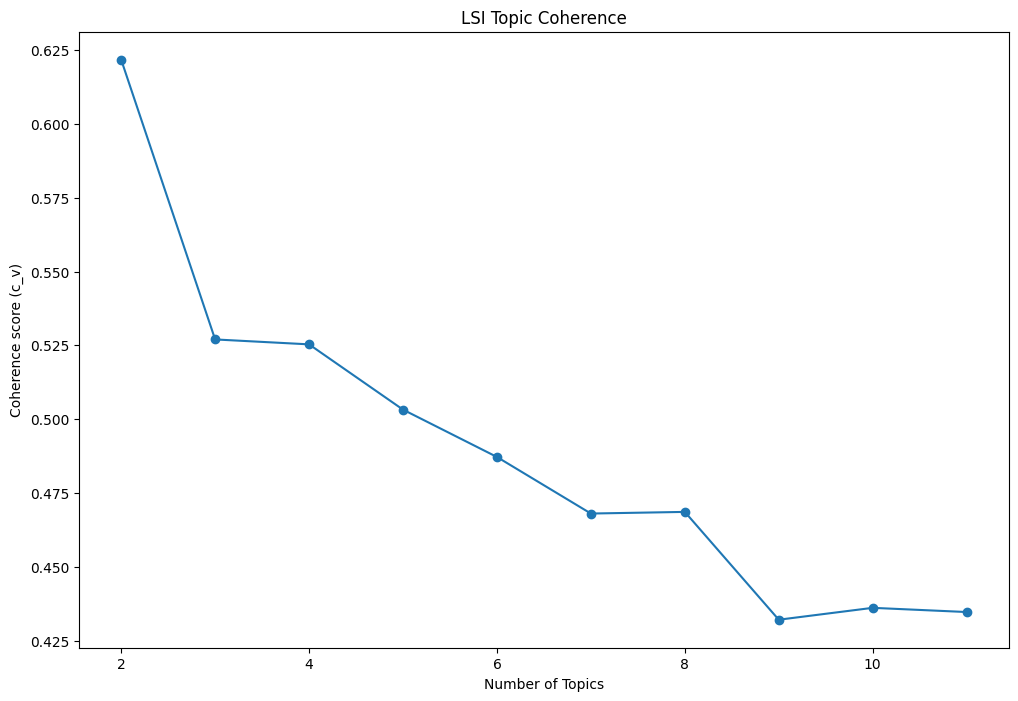

In [81]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

model_list_fake, coherence_values_fake = get_coherence_scores(
    corpus_tfidf_fake,
    dictionary_fake,
    fake_news_text,
    min_topics=2,
    max_topics=11,
    max_docs_for_coh=3000,
    processes=4
)

This shows that the document structure tends to be coarse-grained and only two topics are really needed. This lines up with the binary nature of the problem (real news versus fake news).

In [82]:
# model for fake news data
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=2)
lsa_fake.print_topics()

[(0,
  '0.237*"trump" + 0.223*"mr" + 0.145*"clinton" + 0.128*"republican" + 0.087*"house" + 0.084*"tax" + 0.083*"u" + 0.080*"campaign" + 0.080*"state" + 0.074*"party"'),
 (1,
  '0.386*"korea" + 0.292*"north" + -0.264*"mr" + -0.216*"clinton" + 0.199*"china" + 0.186*"nuclear" + 0.173*"missile" + 0.160*"korean" + 0.132*"iran" + 0.126*"sanction"')]

### Predict fake or factual news ###

Here, fake news detection is approached as a supervised text classification task. Cleaned article text is converted into a bag-of-words representation using a CountVectorizer, then split into training and test sets. Logistic Regression and a linear SVM (via stochastic gradient descent) are trained to predict whether an article is fake or factual, with performance evaluated using accuracy and class-level precision, recall, and F1-scores.

In [148]:
X = [','.join(map(str, l)) for l in df['text_clean']]
Y = df['fake_or_factual']

In [149]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [150]:
countvec = CountVectorizer(
#    min_df=5,           # keep words appearing in at least 5 docs
#    max_df=0.5,         # drop words appearing in >50% of docs
    max_features=50000  # used to improve speed
)

In [151]:
X_bow = countvec.fit_transform(X)   # sparse matrix, still bag-of-words!

X_train, X_test, y_train, y_test = train_test_split(
    X_bow,
    Y,
    test_size=0.3,
    random_state=42
)

In [ ]:
# split into train and test data
#X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

In [152]:
#lr = LogisticRegression(random_state=0).fit(X_train, y_train) # 100 iterations not enough
lr = LogisticRegression(
    random_state=0,
    max_iter=1000,
    solver="lbfgs",   # good for large datasets
    n_jobs=-1         # use all cores 
).fit(X_train, y_train)

In [153]:
y_pred_lr = lr.predict(X_test)

In [156]:
accuracy_score(y_pred_lr, y_test)

0.9500947276003882

In [192]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.94      0.96      0.95     11028
   Fake News       0.96      0.94      0.95     10613

    accuracy                           0.95     21641
   macro avg       0.95      0.95      0.95     21641
weighted avg       0.95      0.95      0.95     21641



In [193]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [195]:
"""
    Plot a confusion matrix for both classification models used.

    Parameters
    ----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    labels : list[str]
        Class labels in the correct order
    model_name : str
        Name of the model (used in the title)
    cmap : matplotlib colormap, optional
        Color map for the matrix
    figsize : tuple, optional
        Figure size
    dpi : int, optional
        Figure resolution
    values_format : str, optional
        Format for cell values ("d", ".2f", etc.)
    """
def plot_confusion_matrix(
    y_true,
    y_pred,
    labels,
    model_name,
    cmap=plt.cm.PuBu,
    figsize=(5.5, 4.8),
    dpi=150,
    values_format="d"
):
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=labels
    )

    disp.plot(
        ax=ax,
        cmap=cmap,
        values_format=values_format,
        colorbar=True
    )

    ax.set_title(f"Confusion Matrix — {model_name}", pad=10)
    plt.tight_layout()
    plt.show()

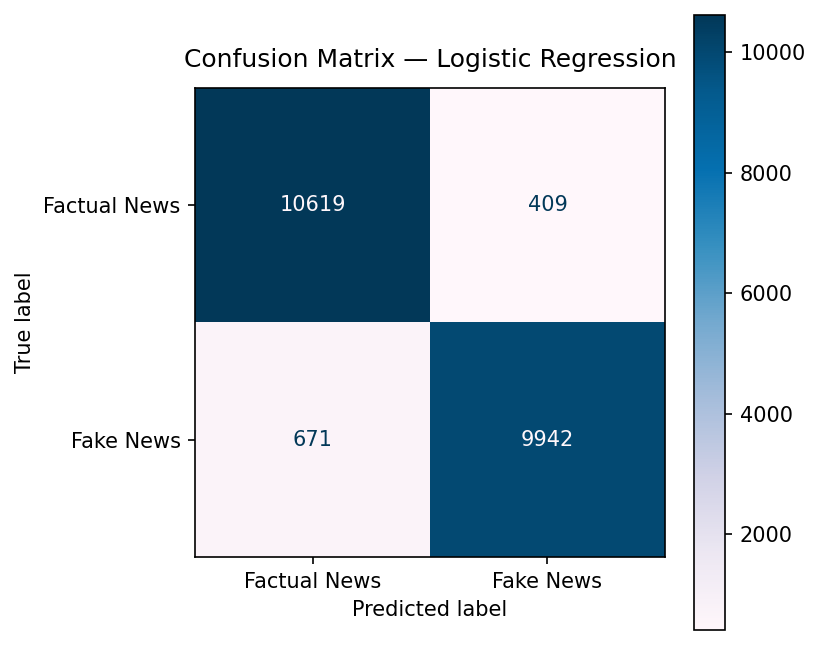

In [196]:
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_lr,
    labels=["Factual News", "Fake News"],
    model_name="Logistic Regression"
)

In [198]:
svm = SGDClassifier().fit(X_train, y_train)

In [199]:
y_pred_svm = svm.predict(X_test)

In [200]:
accuracy_score(y_pred_svm, y_test)

0.9312878332794233

In [201]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.91      0.96      0.93     11028
   Fake News       0.95      0.90      0.93     10613

    accuracy                           0.93     21641
   macro avg       0.93      0.93      0.93     21641
weighted avg       0.93      0.93      0.93     21641



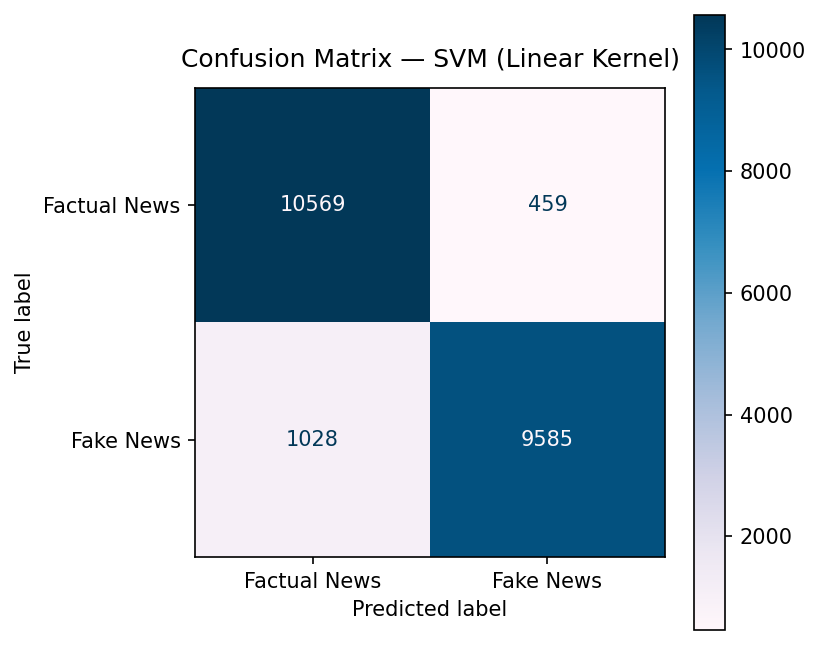

In [202]:
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_svm,
    labels=["Factual News", "Fake News"],
    model_name="SVM (Linear Kernel)"
)

Here, the Logistic Regression model outperformed the SVM model. 

A simple linear decision boundary can prove greater effectiveness for binary classification tasks such as determining if an article should be classified as fake news.